# Naive Bayes On Wisconsin Diagnostic Breast Cancer Dataset

In [5]:
import pandas as pd #读csv
import numpy as np
import matplotlib.pyplot as plt
import math

## 读取数据

In [6]:
df = pd.read_csv('/home/ysq/桌面/BreastCancer/wdbc.data',header=None)

In [7]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 32 columns):
0     569 non-null int64
1     569 non-null object
2     569 non-null float64
3     569 non-null float64
4     569 non-null float64
5     569 non-null float64
6     569 non-null float64
7     569 non-null float64
8     569 non-null float64
9     569 non-null float64
10    569 non-null float64
11    569 non-null float64
12    569 non-null float64
13    569 non-null float64
14    569 non-null float64
15    569 non-null float64
16    569 non-null float64
17    569 non-null float64
18    569 non-null float64
19    569 non-null float64
20    569 non-null float64
21    569 non-null float64
22    569 non-null float64
23    569 non-null float64
24    569 non-null float64
25    569 non-null float64
26    569 non-null float64
27    569 non-null float64
28    569 non-null float64
29    569 non-null float64
30    569 non-null float64
31    569 non-null float64
dtypes: float64(30), int64(1), obj

### df.info()返回了数据集的摘要，可以看出：
- 数据集为569*31的矩阵，即有569条数据，每条数据有31个属性
- 属性0为每个样本的唯一ID，这个属性在分类时用不到，可以删除
- 属性1为非数值型数据，是每个数据为良性或恶性的标记，可作为分类的真值
- 属性2~31为数值型数据，这些属性将作为我们分类时用到的属性，可以认为一个数据是否为良性或恶性由这些属性决定
- 该数据集中没有缺失值

## 数据预处理
- 删除ID列，即第0列
- 对2~31列的数据标准化处理
- 为标签编码
- 增广矩阵：添加一个全1列为偏置做准备

In [8]:
#df = df[~df[0].isin([911296202,865423,8610862])]
#删除第0列
df_ = df.drop(df.columns[0],axis=1)
print(df_.shape) #显示是否删除成功
if df_.shape[1] == df.shape[1]-1:
    print("删除成功")

(569, 31)
删除成功


In [9]:
df_.head() #查看当前数据

,1,2,3,4,5,6,7,8,9,10,...,22,23,24,25,26,27,28,29,30,31
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [10]:
#数据标准化
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()#实例化
df_tmp = df_.drop(df.columns[1],axis=1)
std = scaler.fit_transform(df_tmp) #ndarray
#将ndarray转为dataframe
df_std = pd.DataFrame(std)
df_std.shape

(569, 30)

### 统计数据集中良性(benign)和恶性(malignant)的个数

In [11]:
label_list = df_[1].values.tolist() #将标签列转为列表
dict(zip(*np.unique(label_list, return_counts=True)))
# 有357个良性，212个恶性 
print(label_list)

['M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'B', 'B', 'B', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'B', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'B', 'M', 'B', 'B', 'B', 'B', 'B', 'M', 'M', 'B', 'M', 'M', 'B', 'B', 'B', 'B', 'M', 'B', 'M', 'M', 'B', 'B', 'B', 'B', 'M', 'B', 'M', 'M', 'B', 'M', 'B', 'M', 'M', 'B', 'B', 'B', 'M', 'M', 'B', 'M', 'M', 'M', 'B', 'B', 'B', 'M', 'B', 'B', 'M', 'M', 'B', 'B', 'B', 'M', 'M', 'B', 'B', 'B', 'B', 'M', 'B', 'B', 'M', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'M', 'M', 'M', 'B', 'M', 'M', 'B', 'B', 'B', 'M', 'M', 'B', 'M', 'B', 'M', 'M', 'B', 'M', 'M', 'B', 'B', 'M', 'B', 'B', 'M', 'B', 'B', 'B', 'B', 'M', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'B', 'M', 'B', 'B', 'B', 'B', 'M', 'M', 'B', 'M', 'B', 'B', 'M', 'M', 'B', 'B', 'M', 'M', 'B', 'B', 'B', 'B', 'M', 'B', 'B', 'M', 'M', 'M', 'B', 'M', 'B', 'M', 'B', 'B', 'B', 'M', 'B', 'B', 'M', 'M', 'B', 'M', 'M', 'M', 'M',

### 对标记列进行one-hot编码
- 将M--恶性 编码为1，将B-- 良性编码为0

In [12]:
from sklearn.preprocessing import LabelEncoder
coder = LabelEncoder()#实例化
label = coder.fit_transform(label_list) #y空间
print(label.shape)
#将M--恶性 编码为1，将B-- 良性编码为0

(569,)


#### 将编码后的列作为属性label加入df_std(已标准化后的dataframe)
当前，所有数据已被标准化，data就是X空间，label就是Y空间 

In [13]:
data = df_std.values #X空间

## 绘制混淆矩阵的函数

In [14]:
#绘制混淆矩阵
def confusion_matrix(matrix):
    """
        传入混淆矩阵，绘制图像
    """
    guess = ["malignant","benign"]
    fact = [ "malignant","benign"]
    classes = list(set(fact))
    classes.sort(reverse=True)
    r1=matrix

    plt.figure(figsize=(8,5))       #设置plt窗口的大小
    confusion =r1
    print("confusion",confusion)
    plt.imshow(confusion, cmap=plt.cm.Blues)
    indices = range(len(confusion))
    indices2 = range(3)
    plt.xticks(indices, classes,rotation=40,fontsize=18)
    plt.yticks([0.00,1.00], classes,fontsize=18)
    plt.ylim(1.5 , -0.5)   #设置y的纵坐标的上下限

    plt.title("Confusion matrix",fontdict={'weight':'normal','size': 18})
    #设置color bar的标签大小
    cb=plt.colorbar()
    cb.ax.tick_params(labelsize=10)
    plt.xlabel('Predict label',fontsize=18)
    plt.ylabel('True label',fontsize=18)

    print("len(confusion)",len(confusion))
    for first_index in range(len(confusion)):
        for second_index in range(len(confusion[first_index])):
            if confusion[first_index][second_index]>200:
                color="w"
            else:
                color="black"
            plt.text(first_index, second_index, confusion[first_index][second_index],fontsize=18, color = color,verticalalignment='center',horizontalalignment='center',)
    plt.show()

## 构建模型

In [142]:
class NaiveBayes:
    def __init__(self,X_train,y_train,X_test,y_test):
        """
            初始化,传入训练集的数据和标签以及验证集的数据和标签
            加入高斯参数的字典属性，初始化为空字典
        """
        self.X_train = X_train#训练集数据
        self.y_train = y_train#训练集标签向量
        self.X_test = X_test
        self.y_test = y_test
        self.gaussian_and_prior_parameters = {} #储存高斯分布参数的字典
        
    def computer_gaussian_parameters_and_prior_prob(self):
        """
            计算各类的条件概率和先验概率，通过self.gaussian_parameters带回
            由于该数据集下所有features都为连续型数值变量，
            因此需要使用高斯分布拟合其条件概率P(Xi|c)
            计算不同类别下的条件概率
        """
        #查找训练集中类别为M,B的行向量
        row_index_M = np.where(y_train==1)#类别为M的行数
        row_index_B = np.where(y_train==0)#类别为B的行数
        #计算各类先验概率
        prior_M = len(row_index_M[0])/self.y_train.shape[0]
        prior_B = len(row_index_B[0])/self.y_train.shape[0]
         #计算类别为M或B的数据每列（按属性计算）的均值和方差，返回一个30维向量,且不改变原矩阵维度
        mean = lambda row_index: np.mean(X_train[row_index],axis=0,keepdims=True)
        #均值
        mean_M = mean(row_index_M)
        mean_B = mean(row_index_B)
        
        var = lambda row_index: np.var(X_train[row_index],axis=0,keepdims=True)
        #方差
        var_M = var(row_index_M)
        var_B = var(row_index_B)
        
        parameter_M = {'mean':mean_M,'var':var_M,'prior':prior_M}
        parameter_B = {'mean':mean_B,'var':var_B,'prior':prior_B}
        #将这些参数反馈至结构体中的parameters中
        self.gaussian_and_prior_parameters['1'] = parameter_M
        self.gaussian_and_prior_parameters['0'] = parameter_B
    
    def gaussian_distribution(self,_class):
        """
            传参:_class为类别，可为1或0
            由于需要计算测试集上每个向量在不同类别下的条件概率向量
            而这个条件概率需要由高斯分布密度概率函数计算
            该函数可以根据提供的类别，从self.gaussian_parameters中取出对应的参数计算
            高斯分布概率
            
            返回值为
        """
        #按照类别取出均值向量和方差向量
        mean = self.gaussian_and_prior_parameters[str(_class)]['mean']
        var = self.gaussian_and_prior_parameters[str(_class)]['var']
        #借用numpy的广播机制，使用scalar和ndarray和matrxi混合运算得到一个向量
        #分子 np.exp:Calculate the exponential of all elements in the input array.
        numerator = np.exp(-(self.X_test-mean)**2/(2*var))#numpy中矩阵减向量会自动将矩阵中每行/列减去给定的行/列向量
        #分母
        denominator = (2*np.pi)**0.5*var
        
        ########
        #一开始直接使用连乘，导致数值很小，无法处理
        #我翻阅了sklearn中naivebayes.py的源码，发现它使用了取对数的方法，这里借鉴一下
        ########
        foo = np.log(numerator/denominator)#先对上面运算出的向量每个元素取对数
        probability = np.sum(foo,axis=1)#取对数后相加,axis=1表示按行相加，因为这里我们的向量都为行向量
        return probability
    
    def multiply_probability(self):
        """
            对测试集进行概率相乘，得到贝叶斯分子的对数
        """
        #用于接收训练集样本在不同类别下的贝叶斯公式分子的列表
        hyp = []
        #i设为类别指示器，取值为0，1
        for i in range(2):
            #print(i)
            #计算该类别下的贝叶斯公式分子
            #先算该类别下的先验概率
            prior_prob = self.gaussian_and_prior_parameters[str(i)]['prior']
            ln_prior_prob = np.log(prior_prob)#取对数
            conditional = self.gaussian_distribution(i)#一个列向量，该类别下，训练集中所有样本的条件概率(取对数相加后的列列向量结果)
            conditional += ln_prior_prob#本来相乘，取对数变为相加
            #print(conditional)
            hyp.append(conditional)
        return hyp
    def hypothesis(self):
        """
            根据上面得出的贝叶斯分子的对数进行预测
        """
        hyp = self.multiply_probability()
        hyp = np.array(hyp)
        #利用np.argmax从hyp两行中按列求出大的元素的标号，这个标号正是我们的类别标号
        hyp_ = np.argmax(hyp,axis=0)#预测结果的列向量
        return hyp_

## 进行训练集和测试集的划分
- 使用5折分层交叉验证


------------------第 1 轮
模型训练完毕！参数为:
 {'1': {'mean': array([[ 1.05646172,  0.58668172,  1.06689769,  1.03895307,  0.42094674,
         0.73816951,  0.94160394,  1.05416562,  0.34544517, -0.12767333,
         0.79818689,  0.03769617,  0.7696847 ,  0.79247471, -0.04413874,
         0.36781354,  0.35261257,  0.55658823, -0.0238084 ,  0.06957866,
         1.08406715,  0.61788068,  1.08051831,  1.0359749 ,  0.47696241,
         0.66166087,  0.82006273,  1.01200275,  0.38013331,  0.25772188]]), 'var': array([[0.82463623, 0.78191068, 0.81840268, 1.14001321, 0.77316898,
        1.01115589, 0.94958444, 0.83984209, 0.91498048, 0.94246586,
        1.69428802, 0.73269993, 1.72127817, 2.092663  , 1.05605245,
        1.00773972, 0.53620792, 0.75144475, 1.45220656, 0.54115836,
        0.78882891, 0.78874082, 0.77864786, 1.1455449 , 0.84553487,
        0.96948687, 0.71800612, 0.48102669, 1.19947516, 1.04870035]]), 'prior': 0.3722466960352423}, '0': {'mean': array([[-0.53563597, -0.26241954, -0.5489041

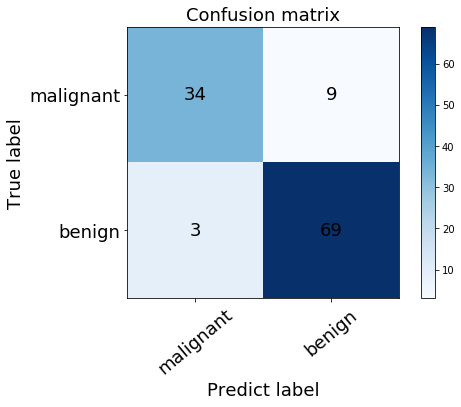

分类正确个数: 103 总样本个数: 115 正确率: 0.8956521739130435

-------------------------------------------------------


------------------第 2 轮
模型训练完毕！参数为:
 {'1': {'mean': array([[ 0.98307177,  0.59024805,  0.99858045,  0.96434838,  0.42663155,
         0.77644252,  0.90296583,  1.00586982,  0.37899496, -0.02503544,
         0.72167377, -0.04740085,  0.71895724,  0.71997062, -0.12106297,
         0.37308402,  0.32747994,  0.53659709, -0.08649554,  0.10265439,
         1.03935448,  0.63815425,  1.0549113 ,  0.99431341,  0.54216376,
         0.81571622,  0.89199947,  1.06631666,  0.53135272,  0.46292436]]), 'var': array([[0.84249528, 0.83266329, 0.81144   , 1.14248327, 0.73895925,
        0.97053619, 0.79161837, 0.72700664, 0.97871931, 1.19567709,
        1.66709805, 0.73077128, 1.73897825, 2.05283626, 0.86348569,
        0.98957067, 0.48281797, 0.82191463, 1.11542735, 0.59924211,
        0.82608251, 0.83782712, 0.78902575, 1.196257  , 0.94173241,
        1.22280594, 0.76357971, 0.50859131, 1.46073863

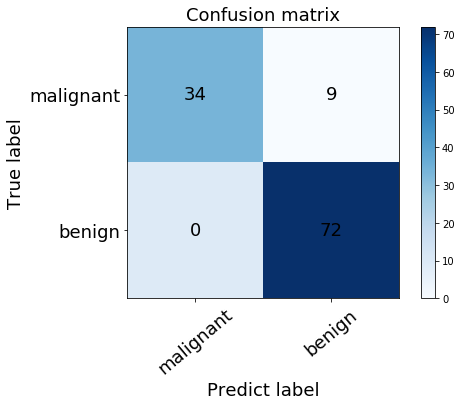

分类正确个数: 106 总样本个数: 115 正确率: 0.9217391304347826

-------------------------------------------------------


------------------第 3 轮
模型训练完毕！参数为:
 {'1': {'mean': array([[ 0.91676509,  0.50098984,  0.93806909,  0.88198721,  0.52359019,
         0.80557752,  0.92477379,  1.03235334,  0.5018508 ,  0.04280024,
         0.75515184,  0.01492156,  0.73607538,  0.70570957, -0.11862523,
         0.36185597,  0.32181977,  0.53404068,  0.01328175,  0.09986134,
         0.98929139,  0.56754132,  1.00560562,  0.93142352,  0.57175128,
         0.76622103,  0.86571983,  1.03638868,  0.56494354,  0.44039637]]), 'var': array([[0.76468927, 0.68895097, 0.75132916, 0.96820452, 0.80105579,
        1.11788609, 0.90891307, 0.7784533 , 1.01254106, 1.19075622,
        1.33950363, 0.79111704, 1.39214109, 1.51325452, 0.60553179,
        0.96388749, 0.44485642, 0.77757764, 1.54521013, 0.56866026,
        0.77011448, 0.72754476, 0.7729303 , 1.08239382, 0.89520387,
        1.22600688, 0.80038081, 0.49620857, 1.4767746 

/home/ysq/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:66: RuntimeWarning: divide by zero encountered in log


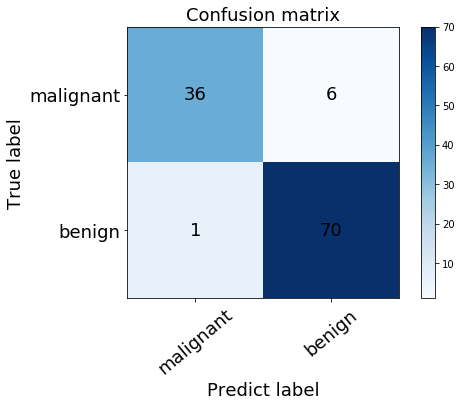

分类正确个数: 106 总样本个数: 113 正确率: 0.9380530973451328

-------------------------------------------------------


------------------第 4 轮
模型训练完毕！参数为:
 {'1': {'mean': array([[ 0.89556426,  0.53641601,  0.91522791,  0.86352731,  0.48686045,
         0.79488889,  0.90721899,  0.98459199,  0.45919919,  0.03259349,
         0.70567169, -0.02422984,  0.69989446,  0.68412071, -0.06043464,
         0.42729473,  0.35341061,  0.54156053,  0.00463746,  0.14384085,
         0.9566698 ,  0.57658394,  0.96797735,  0.89120764,  0.5623704 ,
         0.8173502 ,  0.89041015,  1.02723302,  0.58691681,  0.49691398]]), 'var': array([[0.83777471, 0.7493515 , 0.82362879, 1.11252513, 0.82071602,
        1.0168573 , 0.89680184, 0.774818  , 1.04293509, 1.14442089,
        1.63224921, 0.78537769, 1.7093017 , 1.96887895, 1.04559961,
        1.12378061, 0.53895483, 0.84898282, 1.54373904, 0.63342235,
        0.73371013, 0.72281687, 0.71844395, 0.99951894, 0.91714826,
        1.18910211, 0.78978486, 0.48687847, 1.51274766

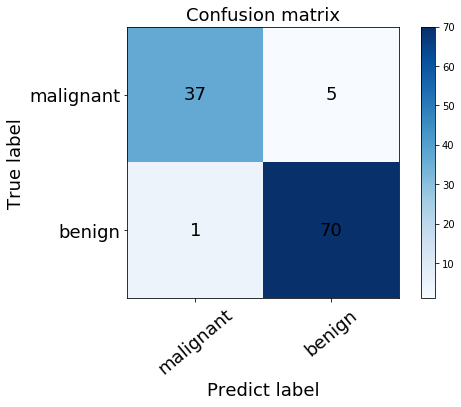

分类正确个数: 107 总样本个数: 113 正确率: 0.9469026548672567

-------------------------------------------------------


------------------第 5 轮
模型训练完毕！参数为:
 {'1': {'mean': array([[ 0.88569059,  0.48012837,  0.90053755,  0.8522998 ,  0.46795556,
         0.75526023,  0.84190212,  0.9622453 ,  0.45812538, -0.00668248,
         0.6993768 , -0.03479253,  0.6841059 ,  0.65541366, -0.09051233,
         0.37092684,  0.29109881,  0.4789476 ,  0.04951983,  0.08980208,
         0.96918002,  0.56481129,  0.97143951,  0.9091549 ,  0.58093619,
         0.77333981,  0.81160941,  1.00712585,  0.63673493,  0.44274339]]), 'var': array([[0.83071969, 0.78720348, 0.80917141, 1.06163494, 0.8647411 ,
        1.08931507, 0.86186364, 0.78664585, 1.10045459, 1.24323887,
        1.37929146, 0.77901777, 1.4808743 , 1.43334894, 1.04497078,
        1.16699296, 0.5478747 , 0.7824167 , 1.7212491 , 0.62169254,
        0.78608123, 0.81697753, 0.76214077, 1.06116251, 0.96692787,
        1.22122425, 0.6956934 , 0.49926518, 1.57593057

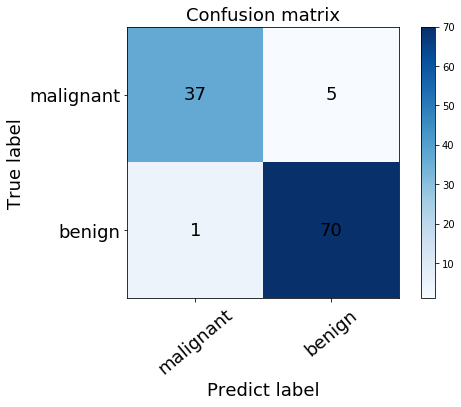

分类正确个数: 107 总样本个数: 113 正确率: 0.9469026548672567

-------------------------------------------------------



In [157]:
from sklearn.model_selection import StratifiedKFold #分层交叉验证
kfold = StratifiedKFold(n_splits=5)#实例化

count = 1 #共5折，表示当前为第几折

#接收每折分类准确率的列表
accuracy = []

#统计TP,FP,TN,FN的列表
statistic_list = []

for train_index,test_index in kfold.split(data,label):
    #print("Train Index:",train_index,",Test Index:",test_index)
    print("\n------------------第",count,"轮")
    
    #划分训练集测试集
    X_train,X_test=data[train_index],data[test_index]#划分X空间
    y_train,y_test=label[train_index],label[test_index]
    
    #进行模型训练 Training
    model = NaiveBayes(X_train,y_train,X_test,y_test)
    model.computer_gaussian_parameters_and_prior_prob()#计算模型的参数
    print("模型训练完毕！参数为:\n",model.gaussian_and_prior_parameters)
    #验证
    hypothesis_vector = model.hypothesis()#预测
    
    #对结果进行评价
    correct = 0 #用correct统计被分类正确样本的个数
    
    #统计用于绘制混淆矩阵的信息
    malignat_malignat = 0 #本来是恶性分类为恶性的样本个数  TP
    malignat_benign = 0#本来是恶性分类为良性的样本个数 FN
    benign_malignat = 0#本来是良性分类为恶性的样本个数 FP
    benign_benign = 0#本来是良性分类为良性的样本个数 TN
    
    for i in range(y_test.shape[0]):
        #检查真值
        #判断混淆矩阵中的计数器谁该增加
        if y_test[i] == 1 and hypothesis_vector[i] == 1:
            malignat_malignat += 1
        if y_test[i] == 1 and hypothesis_vector[i] == 0:
            malignat_benign += 1
        if y_test[i] == 0 and hypothesis_vector[i] == 1:
            benign_malignat += 1
        if y_test[i] == 0 and hypothesis_vector[i] == 0:
            benign_benign += 1
    #绘制混淆矩阵
    conf_matrix = np.array([[malignat_malignat,benign_malignat],[malignat_benign,benign_benign]])
    confusion_matrix(conf_matrix)  
    #精度
    correct = malignat_malignat+benign_benign
    acc = (malignat_malignat+benign_benign)/y_test.shape[0]
    accuracy.append(acc)
    
    #输出TP,FP,TN,FN
    foo = np.array([malignat_malignat,benign_malignat,benign_benign,malignat_benign])
    statistic_list.append(foo)
    
    print("分类正确个数:",correct,"总样本个数:",X_test.shape[0],"正确率:",acc)
    print("\n-------------------------------------------------------\n")
    count = count + 1
    

## 查看模型分类的准确率

In [156]:
print("模型准确率向量",accuracy)
overall = np.mean(accuracy)
print("整体准确率",overall)

模型准确率向量 [0.8956521739130435, 0.9217391304347826, 0.9380530973451328, 0.9469026548672567, 0.9469026548672567]
整体准确率 0.9298499422854946


## 计算模型的召回率(灵敏度)、特效性

In [159]:
#根据statistic_list中的数据计算
for item in statistic_list:
    #item的顺序: TP,FP,TN,FN
    recall = item[0]/(item[0]+item[-1]) #TP/(TP+FN)
    specificity = item[2]/(item[1]+item[2])
    print("recall:",recall," specificity:",specificity)

recall: 0.7906976744186046  specificity: 0.9583333333333334
recall: 0.7906976744186046  specificity: 1.0
recall: 0.8571428571428571  specificity: 0.9859154929577465
recall: 0.8809523809523809  specificity: 0.9859154929577465
recall: 0.8809523809523809  specificity: 0.9859154929577465
